### Setup

In [3]:
# Importations
import pydicom
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend.tensorflow_backend as tfb
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
import pickle
from pathlib import Path
import subprocess
import smtplib, ssl
import random

# Define paths and change directory
dirname = '/home/najmanl/data/rsna-intracranial-hemorrhage-detection/'
path_images = dirname + 'stage_1_train_images/'
path_labels = dirname + 'stage_1_train.csv'
cwd = os.getcwd()
print(cwd)
os.chdir(dirname)

Using TensorFlow backend.


/home/bonandrv


In [4]:
def email_results(content,
                  smtp_server = "smtp.gmail.com", 
                  port = 465, # for SSL
                  sender_email = "eresthina@gmail.com", 
                  receiver_email = "eresthina@gmail.com",
                  password = "jevousestime"):
    """Exports the results by mail."""
    message = """{}""".format(content)
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)

### Dataset

In [27]:
def gather_metadata(path_images):
    """Lists dcm files, stores their paths and patient's indexes."""
    files_metadata = pd.DataFrame({'file_name': os.listdir(path_images)}) # retrieve the files names
    files_metadata['only_images'] = files_metadata['file_name'].apply(lambda f : f[-3:]=='dcm') # find the images (.dcm)
    files_metadata = files_metadata[files_metadata['only_images']==True] # drop the other files names to keep only the images
    files_metadata['file_path'] = files_metadata['file_name'].apply(lambda f : os.path.join(path_images, f)) # paths to the images
    files_metadata['ID'] = files_metadata['file_name'].apply(lambda f : f.replace('.dcm', '').split('_')[1]) # indexes of the patients
    files_metadata.set_index("ID", inplace = True)
    return files_metadata

def ensure_right_dims(files_metadata, nb_samples):
    """"Checks if the image has dimension (512, 512)."""
    dim_list = [None for i in range(files_metadata.shape[0])]
    valid = [None for i in range(files_metadata.shape[0])]
    for i in range(nb_samples):
        file_path = files_metadata['file_path'][i]
        dcmfile = pydicom.read_file(file_path)
        dim_list[i] = (int(dcmfile.Rows), int(dcmfile.Columns))
        valid[i] = (dim_list[i] == (512, 512))
    files_metadata['dims'] = dim_list
    files_metadata['valid'] = valid
    return files_metadata

exclusion_list = ['631f0b556', 'af129aa8e', 'd7229490a', '73dee8958', '3274f5977', '7607dbd07', 'ca4a832a1', 'ac1d14c29', 'ae7b11865', 'd9840380c', 'c64131283', '046ba342c', 'a356248db', '155249efa', 'dfaa49f5c', 'ca9462f49', '9bc2b62cc', '80a2dbc4a', '0b2ec2d3f', 'c35d5c858', 'c65ca5466', 'abcd58e88', 'bb2a4a01c', 'd4ea87a35', '72dce7784', '55f7bbbf2', '4c9fb82af', '04280250b', 'd0c52575a', '1291d1943', '8fc348d44', '942e2f95b', '91b9ce430', '0f8aa5749', 'def2a0e9f', 'cf4d76860', 'c6f2d84be', '9b68c3f5f', '6d7a27643', 'cade293be', '680b2194c', 'de10fdac2', '12a0d6d34', 'a9e98ab5e', 'aef6c6df9', 'f188940f9', 'a432727fd', 'c1ff9eb46', 'd1a1c9a6c', 'fe7327fab', '88b0d8b4f', 'b4adf8739', '75d691728', '4f0317d23', '8dc299456', '8f5d4b696', 'cbbb50e6d', 'a40f9b2de', '830f46cad', 'dfa4e344a', 'b8665a653', 'a2e178cc7', '3c8b72361', 'fdbfb2c17', '12e3b6923', '6c19c9f7b', '21d4bd6f3', '76f88846f', '8a35660d5', '3d7a23dbb', '2b3671dd9', '21053fe7e', 'c6463f07d', '9ece1bb21', 'b76b13444', '4e0bdd2ba', '291edd834', '85900eb84', '5bf2ca43f', '97e5a203e', '25de55880', 'db48a633d', '56ecdf5c1', '36ab2e72a', '75e3f7e5a', '8caa68ebd', 'cef2af72d', '1bb3b44c7', '0603b315e', 'b19f52c76', '0e1861e6d', '10fe2031e', '950a06268', '7714ead69', 'ea0ddbaf9', '079945c27', '155b9c546', '676b0cb59', '807b56a94', '8144c7120', '9da128021', '3d5d23058', 'b055aafa9', 'd3fd5220e', '081f4d071', '9dad2eb09', '19f266244', '97cd49666', 'c60e34466', 'f22730d7b', '798d956d0', 'd1b2d9ad0', 'f145c3cf4', '0e9ac1c5f', '2fd4dda7c', 'a880e377e', 'ff012ee5b', 'f4c2157d8', 'ba7080372', '66131f4c9', 'cb970c6dc', '8c5fc9e44', '403b4fc67', '845f922f4', 'b76de950b', '3e31d57d0', '94463e98f', '6fbc30b5d', '68e45bca7', 'c2738e8b1', 'dabc2a818', 'dd3b5bf4e', '60a1f0e24', '6b1a86148', '567a36143', 'dd083e12a', '3ba8a116c', 'be3fb6c17', 'd6435f3bf', '22069463a', '362423b57', '6cb797177', '64b44f180', '17103c79e', 'ae691dd29', '4e14d0fe8', '176e4f16d', 'a2f9ba4bf', 'd1afb9750', '8d0ca7742', '0144e4030', '53f460f86', '7917d368d', '1690a6499', '7a02fdbea', '6508563e0', '66accd2e4', 'c45659d3d', '5ffae2e26', '9a36e4b0e', '0b0e59911', '3bc141392', 'd7777de78', '882cd57de', 'd3b76ef6e', '91c508c7a', '394ffb5fd', '7e756c43b', '44d57858e', 'cec3997fa', '985fb5e49', 'b194d2a23', 'b77ba3355', '75cbdae68', '61d2718d2', 'f03370d7c', '0de0ab1d8', 'a7e689932', '445a92ac2', 'a9ab8569f', '2e690fe7c', '4e61fb0b2', 'bc97a5f4f', 'c51cbe76b', '1e633cf27', '898ff55b6', '2ac7f01ed', '5dbe845c1', '038f966b9', '8fde47d9f', '8fd6d5047', '184c541fa', 'b12bb2b16', '3f422852d', '27757c171', 'ab474037b', 'd77fa1286', 'a1bb9bc26', '11c4f9f91', 'f1fe5334e', 'b494c2115', 'bd4f3f06f', '23d0b13b7', '7c08b7fb7', '15b3ba199', 'b1cea5abb', '09aeb0bbd', '191369dca', 'c6bbec638', '5ab140176', '6cc19ac41', '451f60160', '6f92e4481', 'b966185b8', '3e60e696d', '53c71fb9d', '10f34fb10', '767c42624', 'b9938c32c', '28d6a694f', '8756b0c04', 'c1a3f037f', '49ecc6164', 'a3128aa77', '7e870621c', 'a23a8193f', '3eb407dd8', 'ced5fabca', '82ec3b736', 'c964e4096', '142f85eb8', '18aac96c0', 'ae1689e1b', '842e85173', '9cdc7295b', 'f23f8e617', '9a3bba619', '37c495912', 'f242fed92', '6a939bc17', '6dcedd2e1', 'c037d5727', '61c646098', '0c4987103', 'ff9674e53', '6b15a7649', '317330708', 'fd5c41761', 'c07d2cb73', '3dcbd1b5e', 'c11582dc9', '3cb1b59bc', 'ea2861e9a', 'ac39010dc', 'f0d55b727', 'c4575f13b', 'a3feeadf4', '1bc5771a7', '69974dd3e', 'ae7020fd1', 'e4b636907', '57d6a6455', 'f4891876d', '9b297fa83', 'f698edc00', '7940bb7d0', 'ac47ba810', '19306ecc5', '28c4609b3']
def exclude_samples(files_metadata, exlusion_list=exclusion_list):
    """Indicates which samples to ignore, based on previous analyses."""
    files_metadata['valid'] = (1 - files_metadata.index.isin(exclusion_list))
    files_metadata = files_metadata[files_metadata['valid']==True]
    return files_metadata

def normalize_data(pixels):
    min_val = np.min(pixels)
    max_val = np.max(pixels)
    pixels = (pixels-min_val)/(max_val-min_val)
    return pixels

def format_images(images_paths, normalize=False):
    """Prepares the images data."""
    if normalize:
        X = np.stack([normalize_data(pydicom.read_file(image).pixel_array) for image in images_paths])
    else:
        X = np.stack([pydicom.read_file(image).pixel_array for image in images_paths])
    X_exp = np.expand_dims(X, axis=3)
    return X_exp
    
def format_labels(path_labels):
    """Prepares the labels."""
    Y = pd.read_csv(path_labels)
    Y['num'] = Y['ID'].apply(lambda id_string : id_string.split('_')[1]) # appends new colum : index of the patient
    Y['tumor_type'] = Y['ID'].apply(lambda id_string : id_string.split('_')[2]) # appends new column : type of the tumor
    Y['doubles'] = Y['ID'].duplicated(keep='first') # duplicated rows, "True" on any row that already appeared below
    Y = Y[Y['doubles'] != True] # drop the duplicated rows
    T = Y.pivot(index='num', columns='tumor_type', values='Label') # reshape the dataframe to wide format
    T['healthy'] = 1 - T['any'] # label for people with no tumor
    T.drop(['any'], axis=1, inplace=True) #  drop the redundant column
    return T

def find_csv(dirname):
    """Retrieves the file name of the csv file containing the labels."""
    list_files = os.listdir(dirname)
    found = []
    for f in list_files:
        if f[-1]=='v':
            found.append(f)
    return found

def get_data(path_images, path_labels, nb_samples=None, fraction_test=0.25):
    """Builds all the data in one step."""
    files_metadata = gather_metadata(path_images) # get files paths and indexes
    files_metadata = exclude_samples(files_metadata) # exclude unappropriate samples
    if nb_samples == None:
        nb_samples = len(files_metadata)
    T = format_labels(path_labels) # get all the labels
        
    ID_train = []
    ID_test = []
    n = int(nb_samples/len(T.columns)) # number of samples to select in each category
    for category in T.columns:
        ID_list = T.index[T[category]==1].tolist() # all the samples falling in the category
        ID_train += ID_list[:int(n*(1-fraction_test))] # divide the IDs between train and test
        ID_test += ID_list[int(n*(1-fraction_test)):n]
    random.shuffle(ID_train) # mixing the categories IDs
    random.shuffle(ID_test)
    
    files_metadata_train = files_metadata[files_metadata.index.isin(ID_train)] # training samples
    files_metadata_test = files_metadata[files_metadata.index.isin(ID_test)] # test samples
    files_metadata_train = files_metadata_train.reindex(ID_train) # order the IDs
    files_metadata_test = files_metadata_test.reindex(ID_test)

    images_train = files_metadata_train['file_path'] # paths of the images of the selected samples
    X_train = format_images(images_train) # prepare the images for the model, only for the selected indexes
    images_test = files_metadata_test['file_path'] 
    X_test = format_images(images_test)
    
    Y_train = T[T.index.isin(ID_train)] # keep the labels of the selected samples
    Y_train = Y_train.reindex(ID_train) # put the labels in the same order as the images
    Y_test = T[T.index.isin(ID_test)] 
    Y_test = Y_test.reindex(ID_test)
    
    print('/// Training data')
    print("Images: {}".format(X_train.shape))
    print("Length of labels vector: {}".format(len(Y_train)))
    print('/// Test data')
    print("Images: {}".format(X_test.shape))
    print("Length of labels vector: {}".format(len(Y_test)))
    
    return X_train, Y_train, files_metadata_train, X_test, Y_test, files_metadata_test, T

#### Preparation of the training and test sets

In [28]:
nb_samples = 3000
X_train, Y_train, files_metadata_train, X_test, Y_test, files_metadata_test, T = get_data(path_images, path_labels, nb_samples)

/// Training data
Images: (2250, 512, 512, 1)
Length of labels vector: 2250
/// Test data
Images: (750, 512, 512, 1)
Length of labels vector: 750


In [37]:
print('''----------------
Images overview
----------------''')
files_metadata_train.head(10)

----------------
Images overview
----------------


,file_name,only_images,file_path,valid
ID,,,,
003c2eb5f,ID_003c2eb5f.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1
009eee20d,ID_009eee20d.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1
02465c92b,ID_02465c92b.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1
066483913,ID_066483913.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1
0211b71ba,ID_0211b71ba.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1
01879be0f,ID_01879be0f.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1
002708b25,ID_002708b25.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1
01d34a5ae,ID_01d34a5ae.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1
014cad1a5,ID_014cad1a5.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,1


In [38]:
print('''----------------
Labels overview
----------------''')
Y_train.head(10)

----------------
Labels overview
----------------


tumor_type,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,healthy
num,,,,,,
003c2eb5f,0,0,0,1,0,0
009eee20d,0,0,0,1,1,0
02465c92b,0,1,0,1,1,0
066483913,1,0,0,1,0,0
0211b71ba,0,1,0,1,0,0
01879be0f,0,1,1,0,0,0
002708b25,0,0,0,0,0,1
01d34a5ae,0,1,0,0,0,0
014cad1a5,0,1,0,0,0,0


#### Exploration of the data

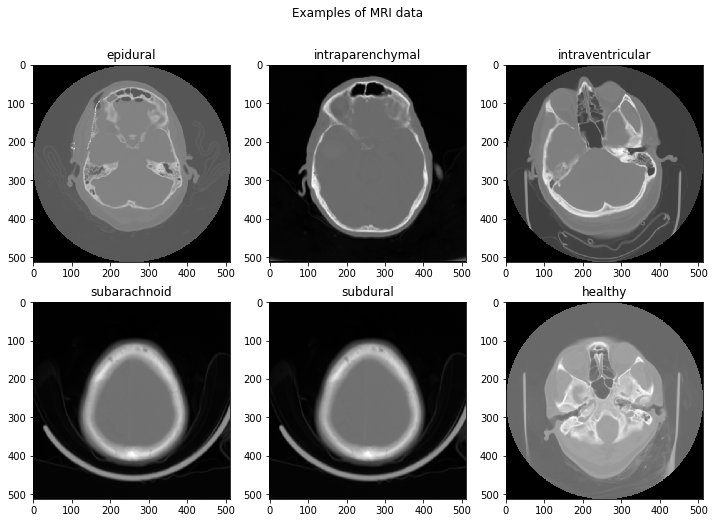

In [30]:
classes = T.columns

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row',figsize=(12,8))
df = files_metadata_train.loc[~files_metadata_train.index.duplicated(keep='first')]
for i in range(len(classes)):
    ax = plt.subplot(2, 3, i+1)
    ID = T[T[classes[i]]==1].index[0]
    if type(df['file_path'][ID])=='str':
        img_path = df['file_path'][ID]      
    else:
        img_path = df['file_path'][ID]
    img = pydicom.read_file(img_path).pixel_array
    ax.imshow(img, cmap='gray')
    ax.set_title(classes[i])
plt.suptitle("Examples of MRI data")
plt.show()

In [33]:
def check_distribution(T):
    effectifs = [T[col].sum() for col in T.columns]
    x = np.arange(len(effectifs))
    plt.bar(x, effectifs)
    plt.xticks(x, T.columns, rotation=45)
    plt.xlabel('Tumor types')
    plt.ylabel('# Samples')
    plt.show()

def check_correlation(T):
    classes = [t for t in T.columns if t != 'healthy']
    corr_mat = T[classes].corr(method ='spearman').to_numpy().round(2)
#     print(corr_mat)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(corr_mat, )
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, corr_mat[i,j], ha="center", va="center", color="w")
    ax.set_title("Correlations between tumors (Spearman)")
    fig.tight_layout()
    plt.show()

Number of missing data in the whole dataset:
tumor_type
epidural            0
intraparenchymal    0
intraventricular    0
subarachnoid        0
subdural            0
healthy             0
dtype: int64
Distribution oftumor types in the whole dataset:


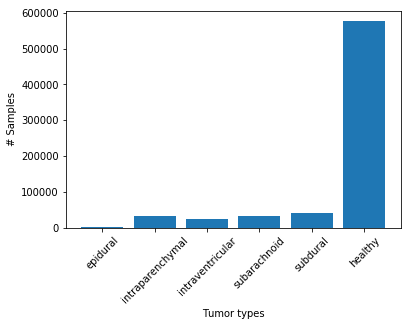

Distribution oftumor types in the training dataset:


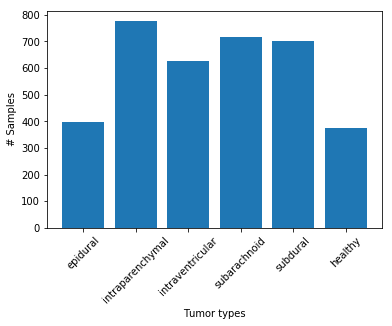

In [35]:
print("Number of missing data in the whole dataset:")
print(T.isnull().sum())

print('Distribution oftumor types in the whole dataset:')
check_distribution(T)

print('Distribution oftumor types in the training dataset:')
check_distribution(Y_train)

Distribution in the training dataset:


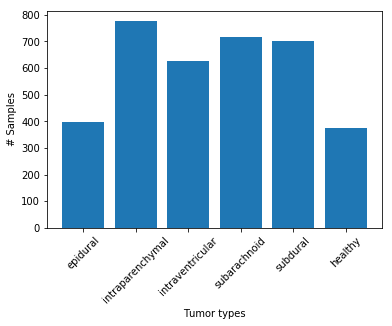

In [36]:
print('Distribution in the training dataset:')
check_distribution(Y_train)

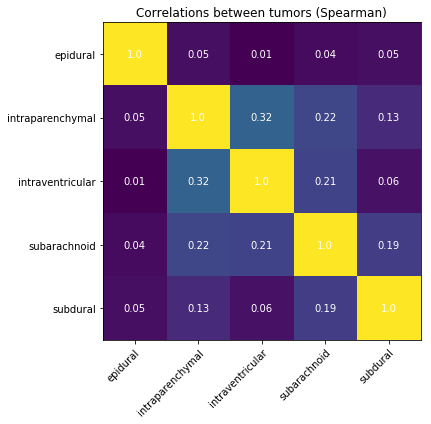

In [34]:
check_correlation(T)

### Fitting the model

In [63]:
def fit_model(X, Y):
    
    K.clear_session()
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3, 3), strides=(2, 2),
                     activation='relu',
                     input_shape=X.shape[1:], padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(300, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.summary()
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])
    
    es = EarlyStopping(monitor='val_recall', mode='max', min_delta=0,
                              patience=5, verbose=1) # stop fitting when overfitting starts
    
    history = model.fit(X, Y,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_split = 0.25,
                    callbacks=[es],
                    class_weight = {0: 4.0, 1:2.0, 2:1.0, 3:4.0, 4:1.0, 5:1.0})
    
    return model, history

In [64]:
model, history = fit_model(X_train, Y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 8)       584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 32)       

------------------------------------------
Training history : model for tumor type {}
------------------------------------------


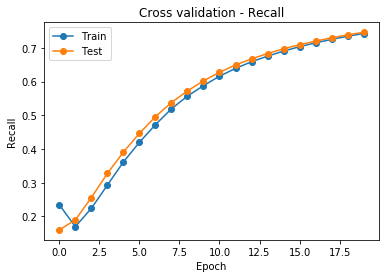

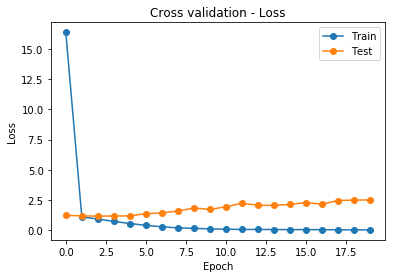

In [69]:
print('''------------------------------------------
Training history : model for tumor type {}
------------------------------------------''')
plt.plot(history.history['recall'], marker='o', label='Train')
plt.plot(history.history['val_recall'], marker='o', label='Test')
plt.title('Cross validation - Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.plot(history.history['loss'], marker='o', label='Train')
plt.plot(history.history['val_loss'], marker='o', label='Test')
plt.title('Cross validation - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation of the model

In [70]:
print('''------------------------------------------
Model evaluation on a test dataset
------------------------------------------''')
_, train_recall = model.evaluate(X_train, Y_train, verbose=0)
_, test_recall = model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_recall, test_recall))

------------------------------------------
Model evaluation on a test dataset
------------------------------------------
Train: 0.753, Test: 0.752


In [71]:
def plot_confusion_matrix(ax, cm, class_label, cmap=plt.cm.Blues):
    tags = ['No', 'Yes']
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    text = ax.text(0, 0, np.round(cm[0,0],2), ha="center", va="center", color="w")
    text = ax.text(1, 1, np.round(cm[1,1],2), ha="center", va="center", color="k")
    text = ax.text(0, 1, np.round(cm[1,0],2), ha="center", va="center", color="k")
    text = ax.text(1, 0, np.round(cm[0,1],2), ha="center", va="center", color="k")
    tick_marks = np.arange(len(tags))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(tags)
    ax.set_yticklabels(tags)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(class_label)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

[[2.80603708e-04 4.70210391e-04 1.06270763e-03 5.49678132e-02
  9.99722302e-01 6.59787212e-04]
 [4.45846780e-07 1.60817464e-04 4.44730904e-06 1.38371466e-02
  1.81319602e-02 9.99723375e-01]
 [5.62254265e-02 1.56470371e-04 7.87758036e-05 3.03861443e-02
  8.26208472e-01 3.12631018e-04]
 ...
 [1.86398408e-09 9.94541824e-01 9.24738705e-01 1.22201127e-05
  2.87906805e-05 1.11447254e-04]
 [1.78340392e-03 9.60589826e-01 2.30413186e-03 6.30238646e-05
  1.15849500e-04 2.88805485e-01]
 [1.01746336e-05 9.98614907e-01 3.70392174e-01 6.55679032e-03
  1.03922073e-04 4.41241497e-03]]


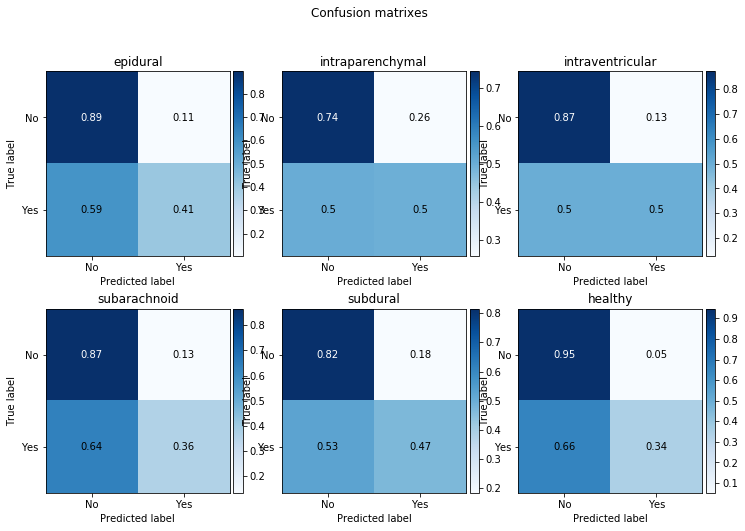

In [72]:
# For multilabel classification :

Y_pred = model.predict(X_test)
Y_true = Y_test.copy()
print(Y_pred)
thresh = 0.5
classes = Y_test.columns
n_classes = len(classes)

CM_list = []
for i in range(n_classes):
    y_true = Y_true[classes[i]]
    y_pred = (Y_pred[:,i] >= thresh)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    CM_list.append(cm)

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row',figsize=(12,8))
for i in range(n_classes):
    ax = plt.subplot(2, 3, i+1)
    plot_confusion_matrix(ax, CM_list[i], class_label=classes[i])
plt.suptitle("Confusion matrixes")
plt.show()

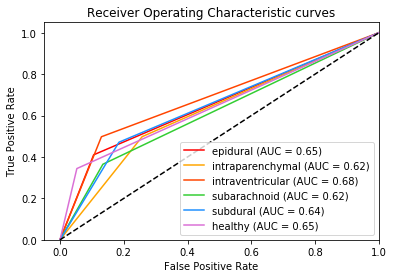

In [73]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_true = Y_true[classes[i]]
    y_pred = (Y_pred[:,i] >= thresh)
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

    
plt.figure()
colors = ['red', 'orange', 'orangered', 'limegreen', 'dodgerblue', 'orchid']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='{0} (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curves')
plt.legend(loc="lower right")
plt.show()

### Long running codes and results

In [109]:
# Finding the samples which have image dimensions different from (512, 512)
path_images = dirname + 'stage_1_train_images/'
fm = gather_metadata(path_images)
nb_samples = files_metadata.shape[0]
fm = ensure_right_dims(fm, nb_samples)

In [143]:
wrong_dims = fm[fm['valid']==False]
email_results(wrong_dims['ID'].tolist())
email_results(wrong_dims['dims'].tolist())
wrong_dims

,file_name,only_images,file_path,ID,dims,valid
621,ID_631f0b556.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,631f0b556,"(638, 490)",False
1374,ID_af129aa8e.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,af129aa8e,"(464, 464)",False
4538,ID_d7229490a.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,d7229490a,"(462, 462)",False
4610,ID_73dee8958.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,73dee8958,"(768, 768)",False
12536,ID_3274f5977.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,3274f5977,"(666, 512)",False
13658,ID_7607dbd07.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,7607dbd07,"(462, 462)",False
16898,ID_ca4a832a1.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,ca4a832a1,"(464, 464)",False
20120,ID_ac1d14c29.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,ac1d14c29,"(436, 436)",False
21815,ID_ae7b11865.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,ae7b11865,"(430, 404)",False
22471,ID_d9840380c.dcm,True,/home/najmanl/data/rsna-intracranial-hemorrhag...,d9840380c,"(464, 464)",False


In [144]:
# Saving the models

path = '/home/bonandrv/'
path2 = path+'models/'
# os.makedirs(os.path.dirname(path2), exist_ok=True)

os.access(path2, os.W_OK) # Check for write access
# subprocess.call(['chmod', '-R', '+w', path2])
os.chmod(path2,  0o444)
os.access(path2, os.W_OK) # Check for write access

# for t in range(len(tumor_types)):
#     tumor = tumor_types[t]
#     model, history = M[t]
#     filename_model = 'model_{}.pkl'.format(tumor)
#     filename_history = 'model_{}_history.pkl'.format(tumor)
#     model.save(filename_model+'.h5')
#     with open(path2+filename_model, 'wb') as file :
#         pickle.dump(model, file)
#     with open(path2+filename_history, 'wb') as file :
#         pickle.dump(history, file)

False